In [49]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

In [50]:
RATIOS = ['L1',
       'L2', 'L3', 'NCL_CF', 'CASH_TA', 'INV_COGS', 'CC_SAL', 'TL_COST',
       'CL_COST', 'SAL_TA', 'EQ_TA', 'EQ_TL', 'CL_CC', 'LTC_NCA', 'TZ',
       'CF_TL', 'CL_TA', 'NCL_TA', 'EBT_REV', 'ROS', 'EAT_REV', 'ROA', 'ROE',
       'CF_TA', 'CF_SAL', 'LABOR_EAT', 'LABOR_REV']

PRIMARY_VALUES = [
    'CA', 'CASH',
       'CL', 'EQ', 'NCL', 'TA', 'TL', 'CC', 'INV', 'CF_NETTO', 'CF_SELFFIN',
       'REV', 'VA', 'OE', 'EAT', 'EBIT', 'SAL', 'COST', 'INT'
]


REDUCED_FEATURE_SET = ['L1', 'L3', 'EQ_TA', 'CL_CC', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']

SKNACE_ONE_HOT = ['sknace_C', 'sknace_F', 'sknace_G', 'sknace_H', 'sknace_M', 'sknace_other']

FINAL_FEATURE_SET = ['L3', 'EQ_TA', 'LTC_NCA', 'CF_TL', 'CL_TA', 'ROA', 'ROE']

In [51]:
training_raw = pd.read_csv('../../DATA/FINAL/final/training_sample.csv')
testing_raw = pd.read_csv('../../DATA/FINAL/final/testing_sample.csv')
training_raw.shape, testing_raw.shape

((7188, 107), (1797, 107))

In [52]:
SAL_CLASSES = training_raw['sal_class'].unique()
SKNACE_GROUPS = training_raw['sknace_division_normalized'].unique()

In [53]:
training_filled = training_raw.copy()
testing_filled = testing_raw.copy()

In [115]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline




Q = training_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

control_group_ratio = 1.5

training_balanced = (
    pd.concat(
        [
            training_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q * control_group_ratio)),
            training_filled.query('combined_issue_criteria_3y_off == 1').sample(Q),
        ], axis = 0
    )
)



Q_test = testing_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

testing_balanced = (
    pd.concat(
        [
            testing_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q_test * control_group_ratio)),
            testing_filled.query('combined_issue_criteria_3y_off == 1').sample(Q_test),
        ], axis = 0
    )
)


X_train_balanced = training_balanced[REDUCED_FEATURE_SET + SKNACE_ONE_HOT].values
y_train_balanced = training_balanced['combined_issue_criteria_3y_off'].values

X_test_balanced = testing_balanced[REDUCED_FEATURE_SET + SKNACE_ONE_HOT].values
y_test_balanced = testing_balanced['combined_issue_criteria_3y_off'].values

X_train_imbalanced = training_filled[REDUCED_FEATURE_SET + SKNACE_ONE_HOT].values
y_train_imbalanced = training_filled['combined_issue_criteria_3y_off'].values

X_test_imbalanced = testing_filled[REDUCED_FEATURE_SET + SKNACE_ONE_HOT].values
y_test_imbalanced = testing_filled['combined_issue_criteria_3y_off'].values

X_train_valid_balanced, X_valid_valid_balanced, y_train_valid_balanced, y_valid_valid_balanced = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)


X_train_valid_imbalanced, X_valid_valid_imbalanced, y_train_valid_imbalanced, y_valid_valid_imbalanced = train_test_split(
    X_train_imbalanced, y_train_imbalanced, test_size=0.2, random_state=42)


In [116]:
print(X_train_balanced.shape, X_test_balanced.shape)
print(X_train_imbalanced.shape, X_test_imbalanced.shape)

(1750, 17) (430, 17)
(7188, 17) (1797, 17)


In [117]:
print('\nTEST')
print(pd.Series(y_test_balanced).value_counts())
print(pd.Series(y_test_imbalanced).value_counts())

print('\nTRAIN')
print(pd.Series(y_train_balanced).value_counts())
print(pd.Series(y_train_imbalanced).value_counts())

print('\nTRAIN W VALID')
print(pd.Series(y_train_valid_balanced).value_counts())
print(pd.Series(y_train_valid_imbalanced).value_counts())

print('\nVALID')
print(pd.Series(y_valid_valid_balanced).value_counts())
print(pd.Series(y_valid_valid_imbalanced).value_counts())


TEST
0.0    258
1.0    172
dtype: int64
0.0    1625
1.0     172
dtype: int64

TRAIN
0.0    1050
1.0     700
dtype: int64
0.0    6488
1.0     700
dtype: int64

TRAIN W VALID
0.0    842
1.0    558
dtype: int64
0.0    5183
1.0     567
dtype: int64

VALID
0.0    208
1.0    142
dtype: int64
0.0    1305
1.0     133
dtype: int64


In [118]:

from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, fbeta_score, f1_score


# Create a custom scorer for use in GridSearchCV or RFECV
f05_scorer = make_scorer(fbeta_score, beta=0.5)
f2_scorer = make_scorer(fbeta_score, beta=2)
f3_scorer = make_scorer(fbeta_score, beta=3)


# Define a custom scoring function
def custom_score(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    # Weight recall more heavily
    return 0.8 * recall + 0.2 * accuracy

custom_scorer = make_scorer(custom_score, greater_is_better=True)


def eval(real, pred, label):
    print(f'real_positives = {sum(real)}, total = {len(real)}')
    recall = recall_score(real, pred)
    accuracy = accuracy_score(real, pred)
    print(f"{label} Accuracy:", accuracy)
    print(f"{label} Precision:", precision_score(real, pred))
    print(f"{label} Recall:", recall)
    print(f"{label} Balanced Accuracy:", balanced_accuracy_score(real, pred))
    print(f"{label} F1 Score:", f1_score(real, pred))
    # print(f"{label} F2 Score:", fbeta_score(real, pred, beta=2))
    print(f"{label} F0.5 Score:", fbeta_score(real, pred, beta=0.5))
    print(f"{label} Custom Scorer:", custom_score(real, pred))

    cm = confusion_matrix(real, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(label)
    plt.show()

## Decision Tree Classifier

Selected Features: [False False  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True]
Feature Ranking: [4 3 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1]
real_positives = 558.0, total = 1400
Balanced train Accuracy: 0.7357142857142858
Balanced train Precision: 0.6814671814671814
Balanced train Recall: 0.6326164874551972
Balanced train Balanced Accuracy: 0.7183272461028956
Balanced train F1 Score: 0.6561338289962826
Balanced train F0.5 Score: 0.6711026615969581
Balanced train Custom Scorer: 0.6532360471070149


c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` ha

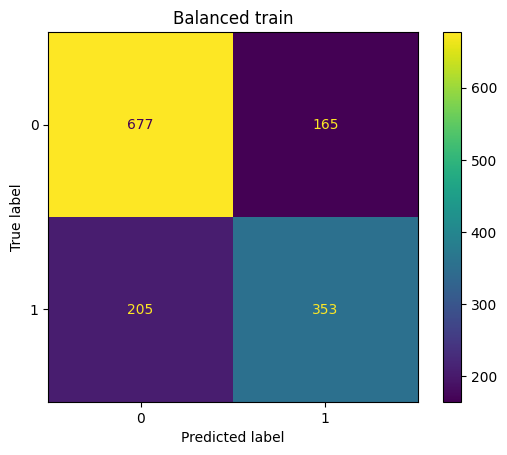

real_positives = 142.0, total = 350
Balanced test Accuracy: 0.7257142857142858
Balanced test Precision: 0.6854838709677419
Balanced test Recall: 0.5985915492957746
Balanced test Balanced Accuracy: 0.7055457746478873
Balanced test F1 Score: 0.6390977443609023
Balanced test F0.5 Score: 0.6661442006269592
Balanced test Custom Scorer: 0.6240160965794769


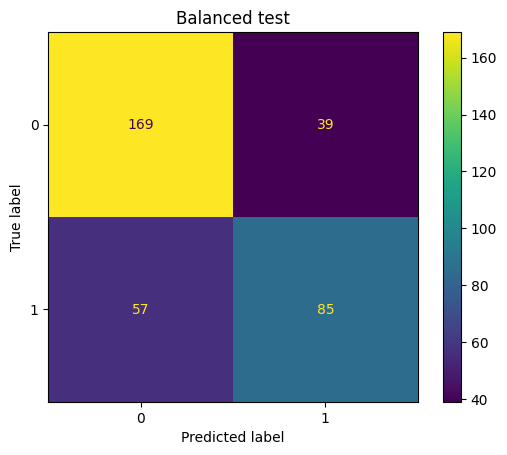

real_positives = 133.0, total = 1438
Imbalanced test Accuracy: 0.8129346314325452
Imbalanced test Precision: 0.2861635220125786
Imbalanced test Recall: 0.6842105263157895
Imbalanced test Balanced Accuracy: 0.7551320830812664
Imbalanced test F1 Score: 0.4035476718403548
Imbalanced test F0.5 Score: 0.3238434163701068
Imbalanced test Custom Scorer: 0.7099553473391407


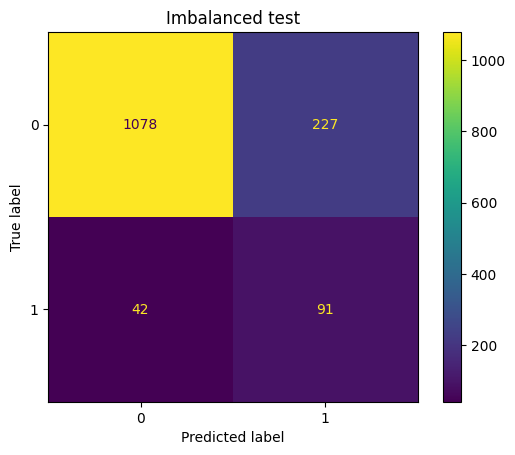

In [120]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, fbeta_score


# Create a Decision Tree classifier
dt = (DecisionTreeClassifier(
        random_state=42,
    criterion = 'gini',
    max_depth=  15,
    max_features= 'auto',
    min_samples_leaf= 5,
    min_samples_split= 40,
    min_impurity_decrease= 0.01))

# Create RFECV object with Decision Tree as the estimator
dt_rfe = RFECV(estimator=dt, step=1, cv=5, scoring='f1', n_jobs=4)

# Fit RFECV
dt_rfe.fit(X_train_balanced, y_train_balanced)

# Transform the data
X_train_selected = dt_rfe.transform(X_train_valid_balanced)
X_valid_selected = dt_rfe.transform(X_valid_valid_imbalanced)
X_valid_selected_balanced = dt_rfe.transform(X_valid_valid_balanced)

# Train a new classifier using only selected features
dt_final = (DecisionTreeClassifier(
        random_state=42,
    criterion = 'gini',
    max_depth=  15,
    max_features= 'auto',
    min_samples_leaf= 5,
    min_samples_split= 40,
    min_impurity_decrease= 0.01))

dt_final.fit(X_train_selected, y_train_valid_balanced)

# Predict and calculate accuracy
y_pred = dt_final.predict(X_valid_selected)
y_pred_balanced = dt_final.predict(X_valid_selected_balanced)
y_pred_train = dt_final.predict(X_train_selected)

print("Selected Features:", dt_rfe.support_)
print("Feature Ranking:", dt_rfe.ranking_)


eval(y_train_valid_balanced, y_pred_train, 'Balanced train')
eval(y_valid_valid_balanced, y_pred_balanced, 'Balanced test')
eval(y_valid_valid_imbalanced, y_pred, 'Imbalanced test')


In [121]:
display(pd.DataFrame(zip((REDUCED_FEATURE_SET), dt_rfe.support_, dt_rfe.ranking_), columns=['feature', 'include', 'ranking']).sort_values(by='ranking', ascending=True))

FINAL_FEATURE_SET = list(pd.DataFrame(zip((REDUCED_FEATURE_SET), dt_rfe.support_, dt_rfe.ranking_), columns=['feature', 'include', 'ranking']).query('ranking <= 2')['feature'])
print(FINAL_FEATURE_SET)

,feature,include,ranking
2,EQ_TA,True,1
4,LTC_NCA,True,1
5,TZ,True,1
6,CF_TL,True,1
7,CL_TA,True,1
8,ROS,True,1
9,ROA,True,1
10,ROE,True,1
3,CL_CC,False,2
1,L3,False,3


['EQ_TA', 'CL_CC', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']


In [145]:

Q = training_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

control_group_ratio = 1.5

training_balanced = (
    pd.concat(
        [
            training_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q * control_group_ratio)),
            training_filled.query('combined_issue_criteria_3y_off == 1').sample(Q),
        ], axis = 0
    )
)



Q_test = testing_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

testing_balanced = (
    pd.concat(
        [
            testing_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q_test * control_group_ratio)),
            testing_filled.query('combined_issue_criteria_3y_off == 1').sample(Q_test),
        ], axis = 0
    )
)


X_train_balanced = training_balanced[REDUCED_FEATURE_SET + SKNACE_ONE_HOT].values
y_train_balanced = training_balanced['combined_issue_criteria_3y_off'].values

X_test_balanced = testing_balanced[REDUCED_FEATURE_SET + SKNACE_ONE_HOT].values
y_test_balanced = testing_balanced['combined_issue_criteria_3y_off'].values

X_train_imbalanced = training_filled[REDUCED_FEATURE_SET + SKNACE_ONE_HOT].values
y_train_imbalanced = training_filled['combined_issue_criteria_3y_off'].values

X_test_imbalanced = testing_filled[REDUCED_FEATURE_SET + SKNACE_ONE_HOT].values
y_test_imbalanced = testing_filled['combined_issue_criteria_3y_off'].values



X_train_valid_balanced, X_valid_valid_balanced, y_train_valid_balanced, y_valid_valid_balanced = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)


X_train_valid_imbalanced, X_valid_valid_imbalanced, y_train_valid_imbalanced, y_valid_valid_imbalanced = train_test_split(
    X_train_imbalanced, y_train_imbalanced, test_size=0.2, random_state=42)


In [135]:
from sklearn.model_selection import GridSearchCV


# # first generation
# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 5, 10, 15],
#     'min_samples_split': [10, 20, 50, 100],
#     'min_samples_leaf': [5, 10, 20, 50],
#     'min_impurity_decrease': [0.1, 0.001, 0.0001, 0.0],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# second generation
param_grid = {'criterion': ['entropy', 'gini'],
 'max_depth': [None, 5, 8, 10, 15, 25],
 'max_features': ['log2', 'auto', 'sqrt'],
 'min_impurity_decrease': [0.0, 0.1, 0.01, 0.001, 0.0001, 0.00001],
 'min_samples_leaf': [1, 2, 3, 5, 10, 15, 20],
 'min_samples_split': [10, 20, 30, 40, 50, 60]}



rf = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=4, verbose=10, scoring='f1')
grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 9072 candidates, totalling 45360 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=4,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 5, 8, 10, 15, 25],
                         'max_features': ['log2', 'auto', 'sqrt'],
                         'min_impurity_decrease': [0.0, 0.1, 0.01, 0.001,
                                                   0.0001, 1e-05],
                         'min_samples_leaf': [1, 2, 3, 5, 10, 15, 20],
                         'min_samples_split': [10, 20, 30, 40, 50, 60]},
             scoring='f1', verbose=10)

In [136]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'log2',
 'min_impurity_decrease': 0.01,
 'min_samples_leaf': 10,
 'min_samples_split': 20}

In [137]:
# Extract grid search results
cv_results = pd.DataFrame(grid_search.cv_results_)

# Display grid search results
# print(cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])

# Sort by rank to see the best combinations first
sorted_cv_results = cv_results.sort_values(by='rank_test_score')
sorted_cv_results.head(40)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
109,0.004816,0.003932,0.000000,0.000000,entropy,None,log2,0.01,10,20,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.679487,0.661710,0.671587,0.681481,0.673913,0.673636,0.006961,1
3867,0.006426,0.003213,0.001597,0.003194,entropy,25,log2,0.01,1,40,"{'criterion': 'entropy', 'max_depth': 25, 'max...",0.679487,0.683274,0.650000,0.649275,0.677116,0.667831,0.014985,2
5643,0.003199,0.003917,0.003469,0.003777,gini,5,auto,0.01,3,40,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.666667,0.669039,0.647059,0.676259,0.678466,0.667498,0.011116,3
6153,0.003255,0.003987,0.003254,0.003985,gini,8,log2,0.01,5,40,"{'criterion': 'gini', 'max_depth': 8, 'max_fea...",0.666667,0.662295,0.690391,0.642066,0.662420,0.664768,0.015409,4
3893,0.006470,0.003236,0.001599,0.003198,entropy,25,log2,0.01,10,60,"{'criterion': 'entropy', 'max_depth': 25, 'max...",0.689231,0.688963,0.661654,0.631579,0.649351,0.664156,0.022498,5
8671,0.002423,0.003211,0.003839,0.003631,gini,25,auto,0.01,5,20,"{'criterion': 'gini', 'max_depth': 25, 'max_fe...",0.673267,0.666667,0.673540,0.644689,0.662420,0.664117,0.010577,6
3375,0.004640,0.005140,0.004017,0.003336,entropy,15,auto,0.01,3,40,"{'criterion': 'entropy', 'max_depth': 15, 'max...",0.679487,0.657143,0.673401,0.622407,0.686469,0.663781,0.022847,7
5646,0.000000,0.000000,0.003239,0.003968,gini,5,auto,0.01,5,10,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.666667,0.680000,0.622378,0.657244,0.678466,0.660951,0.020995,8
7898,0.001599,0.003198,0.003251,0.003982,gini,15,auto,0.01,1,30,"{'criterion': 'gini', 'max_depth': 15, 'max_fe...",0.671141,0.688963,0.647059,0.633803,0.662420,0.660677,0.019080,9
8654,0.008138,0.000157,0.000000,0.000000,gini,25,auto,0.01,1,30,"{'criterion': 'gini', 'max_depth': 25, 'max_fe...",0.671141,0.675585,0.647059,0.627306,0.675410,0.659300,0.019175,10


In [139]:
head = cv_results.sort_values(by='rank_test_score').head(8)


new_params = dict()

for param_name in ['param_criterion', 'param_max_depth', 'param_max_features', 'param_min_impurity_decrease', 'param_min_samples_leaf', 'param_min_samples_split']:
    new_params[param_name] = list(head[param_name].unique())

display(new_params)      



{'param_criterion': ['entropy', 'gini'],
 'param_max_depth': [None, 25, 5, 8, 15],
 'param_max_features': ['log2', 'auto'],
 'param_min_impurity_decrease': [0.01],
 'param_min_samples_leaf': [10, 1, 3, 5],
 'param_min_samples_split': [20, 40, 60, 10]}

## VALIDATION

In [140]:
pd.Series(y_valid_valid_imbalanced).value_counts()

0.0    1305
1.0     133
dtype: int64

In [141]:
def predict_w_threshold(estimator, X, threshold):
    proba = estimator.predict_proba(X)[:, 1]
    return (proba >= threshold).astype(int)

real_positives = 142.0, total = 350
SEMIFINAL MODEL BALANCED Accuracy: 0.7171428571428572
SEMIFINAL MODEL BALANCED Precision: 0.8115942028985508
SEMIFINAL MODEL BALANCED Recall: 0.39436619718309857
SEMIFINAL MODEL BALANCED Balanced Accuracy: 0.6659330985915493
SEMIFINAL MODEL BALANCED F1 Score: 0.5308056872037915
SEMIFINAL MODEL BALANCED F0.5 Score: 0.6698564593301436
SEMIFINAL MODEL BALANCED Custom Scorer: 0.45892152917505036


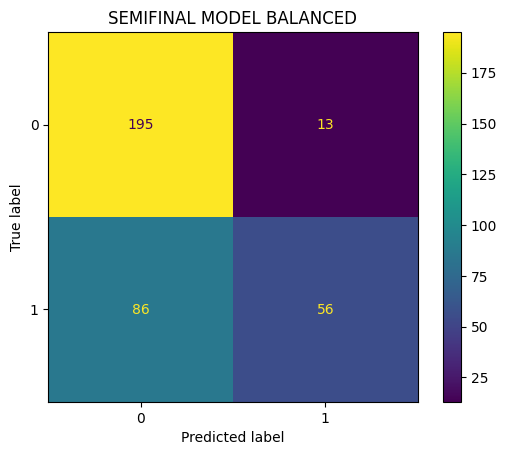

real_positives = 133.0, total = 1438
SEMIFINAL MODEL IMBALANCED Accuracy: 0.8713490959666204
SEMIFINAL MODEL IMBALANCED Precision: 0.34523809523809523
SEMIFINAL MODEL IMBALANCED Recall: 0.43609022556390975
SEMIFINAL MODEL IMBALANCED Balanced Accuracy: 0.675899518912223
SEMIFINAL MODEL IMBALANCED F1 Score: 0.3853820598006644
SEMIFINAL MODEL IMBALANCED F0.5 Score: 0.36024844720496896
SEMIFINAL MODEL IMBALANCED Custom Scorer: 0.523141999644452


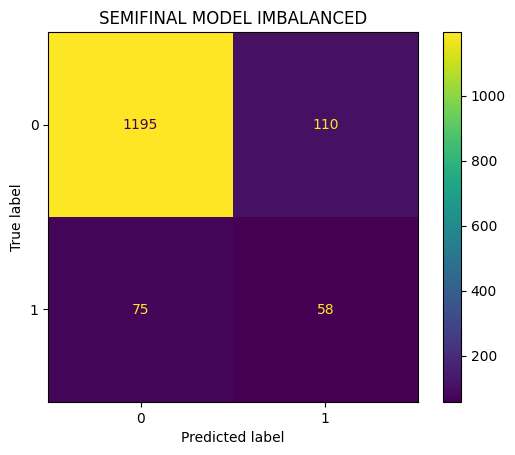

real_positives = 133.0, total = 1438
SEMIFINAL MODEL IMBALANCED W THRESHOLD Accuracy: 0.47913769123783034
SEMIFINAL MODEL IMBALANCED W THRESHOLD Precision: 0.14186046511627906
SEMIFINAL MODEL IMBALANCED W THRESHOLD Recall: 0.9172932330827067
SEMIFINAL MODEL IMBALANCED W THRESHOLD Balanced Accuracy: 0.6758879958516981
SEMIFINAL MODEL IMBALANCED W THRESHOLD F1 Score: 0.2457200402819738
SEMIFINAL MODEL IMBALANCED W THRESHOLD F0.5 Score: 0.17072488105233694
SEMIFINAL MODEL IMBALANCED W THRESHOLD Custom Scorer: 0.8296621247137315


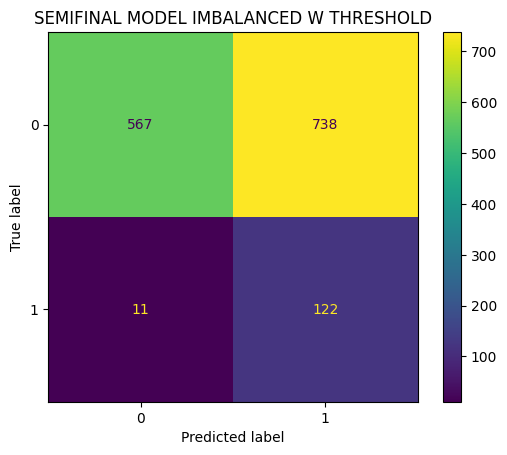

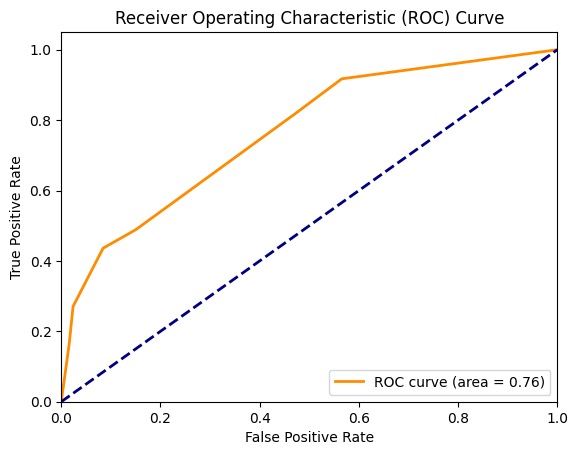

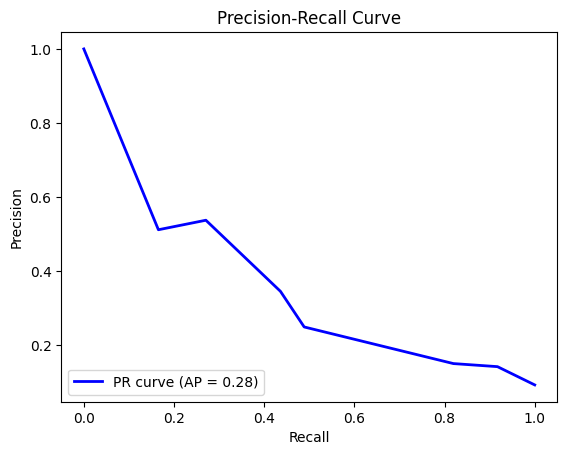

Threshold for 70% recall: 0.15384615384615385
Actual recall: 1.00


In [146]:


rf_final = (DecisionTreeClassifier(
    random_state=42,
    criterion = 'entropy',
    max_depth=  None,
    max_features= 'log2',
    min_samples_leaf= 10,
    min_samples_split= 40,
    min_impurity_decrease= 0.01))



# rf_base.fit(X_train_valid_balanced, y_train_valid_balanced)
rf_final.fit(X_train_valid_balanced, y_train_valid_balanced)


# eval(y_valid_valid_balanced, rf_base.predict(X_valid_valid_balanced), 'BASE MODEL BALANCED')
# eval(y_valid_valid_imbalanced, rf_base.predict(X_valid_valid_imbalanced), 'BASE MODEL IMBALANCED')

eval(y_valid_valid_balanced, rf_final.predict(X_valid_valid_balanced), 'SEMIFINAL MODEL BALANCED')
eval(y_valid_valid_imbalanced, rf_final.predict(X_valid_valid_imbalanced), 'SEMIFINAL MODEL IMBALANCED')
eval(y_valid_valid_imbalanced, predict_w_threshold(rf_final, X_valid_valid_imbalanced, 0.3), 'SEMIFINAL MODEL IMBALANCED W THRESHOLD')

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

y_probs = rf_final.predict_proba(X_valid_valid_imbalanced)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_valid_valid_imbalanced, y_probs)

# Compute the AUC score
roc_auc = roc_auc_score(y_valid_valid_imbalanced, y_probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_valid_valid_imbalanced, y_probs)

# Compute average precision score
average_precision = average_precision_score(y_valid_valid_imbalanced, y_probs)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()




# Find the threshold that achieves the target recall (70%)
target_recall = 0.70
threshold = thresholds[np.argmax(recall >= target_recall)]

# Predict using the new threshold
y_pred = (y_probs >= threshold).astype(int)

# Calculate the recall score with the new threshold
actual_recall = recall_score(y_valid_valid_imbalanced, y_pred)


print(f"Threshold for 70% recall: {threshold}")
print(f"Actual recall: {actual_recall:.2f}")

## FINAL TESTING

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.6837209302325581
FINAL MODEL BALANCED Precision: 0.5882352941176471
FINAL MODEL BALANCED Recall: 0.6976744186046512
FINAL MODEL BALANCED Balanced Accuracy: 0.686046511627907
FINAL MODEL BALANCED F1 Score: 0.6382978723404256
FINAL MODEL BALANCED F0.5 Score: 0.6072874493927126
FINAL MODEL BALANCED Custom Scorer: 0.6948837209302325


c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


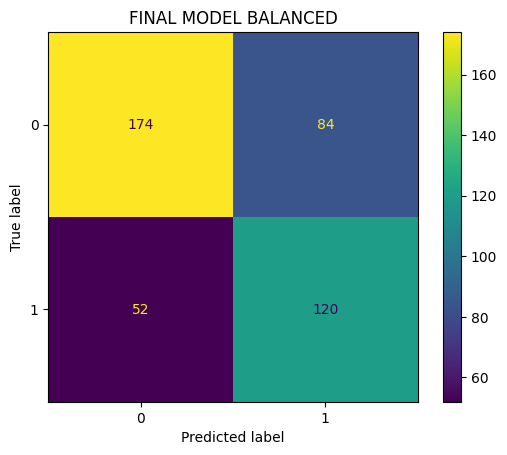

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.6304952698942682
FINAL MODEL IMBALANCED Precision: 0.16393442622950818
FINAL MODEL IMBALANCED Recall: 0.6976744186046512
FINAL MODEL IMBALANCED Balanced Accuracy: 0.6605295169946332
FINAL MODEL IMBALANCED F1 Score: 0.26548672566371684
FINAL MODEL IMBALANCED F0.5 Score: 0.19354838709677416
FINAL MODEL IMBALANCED Custom Scorer: 0.6842385888625746


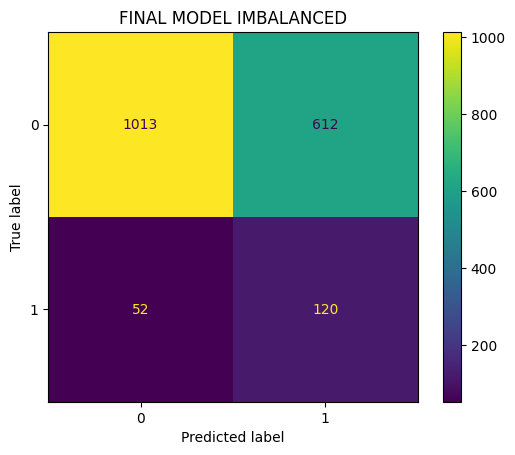

real_positives = 172.0, total = 430
FINAL MODEL W THRESHOLD BALANCED Accuracy: 0.6837209302325581
FINAL MODEL W THRESHOLD BALANCED Precision: 0.5882352941176471
FINAL MODEL W THRESHOLD BALANCED Recall: 0.6976744186046512
FINAL MODEL W THRESHOLD BALANCED Balanced Accuracy: 0.686046511627907
FINAL MODEL W THRESHOLD BALANCED F1 Score: 0.6382978723404256
FINAL MODEL W THRESHOLD BALANCED F0.5 Score: 0.6072874493927126
FINAL MODEL W THRESHOLD BALANCED Custom Scorer: 0.6948837209302325


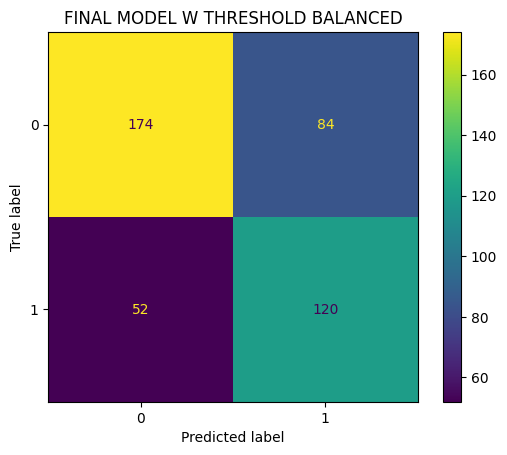

real_positives = 172.0, total = 1797
FINAL MODEL W THRESHOLD IMBALANCED Accuracy: 0.6304952698942682
FINAL MODEL W THRESHOLD IMBALANCED Precision: 0.16393442622950818
FINAL MODEL W THRESHOLD IMBALANCED Recall: 0.6976744186046512
FINAL MODEL W THRESHOLD IMBALANCED Balanced Accuracy: 0.6605295169946332
FINAL MODEL W THRESHOLD IMBALANCED F1 Score: 0.26548672566371684
FINAL MODEL W THRESHOLD IMBALANCED F0.5 Score: 0.19354838709677416
FINAL MODEL W THRESHOLD IMBALANCED Custom Scorer: 0.6842385888625746


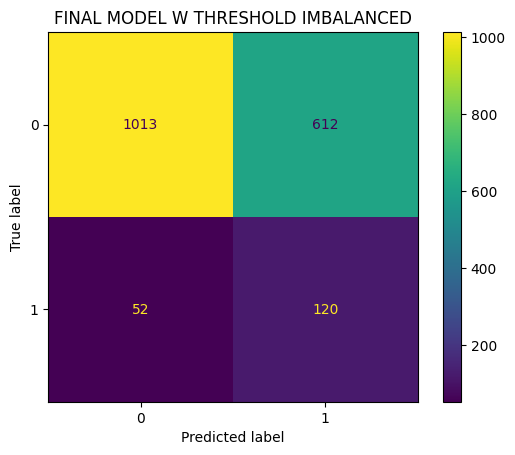

In [147]:

rf_final = (DecisionTreeClassifier(
        random_state=42,
    criterion = 'gini',
    max_depth=  15,
    max_features= 'auto',
    min_samples_leaf= 5,
    min_samples_split= 40,
    min_impurity_decrease= 0.01))


rf_final.fit(X_train_balanced, y_train_balanced)


eval(y_test_balanced, rf_final.predict(X_test_balanced), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, rf_final.predict(X_test_imbalanced), 'FINAL MODEL IMBALANCED')

eval(y_test_balanced,predict_w_threshold(rf_final, X_test_balanced, 0.3), 'FINAL MODEL W THRESHOLD BALANCED')
eval(y_test_imbalanced, predict_w_threshold(rf_final, X_test_imbalanced, 0.3), 'FINAL MODEL W THRESHOLD IMBALANCED')


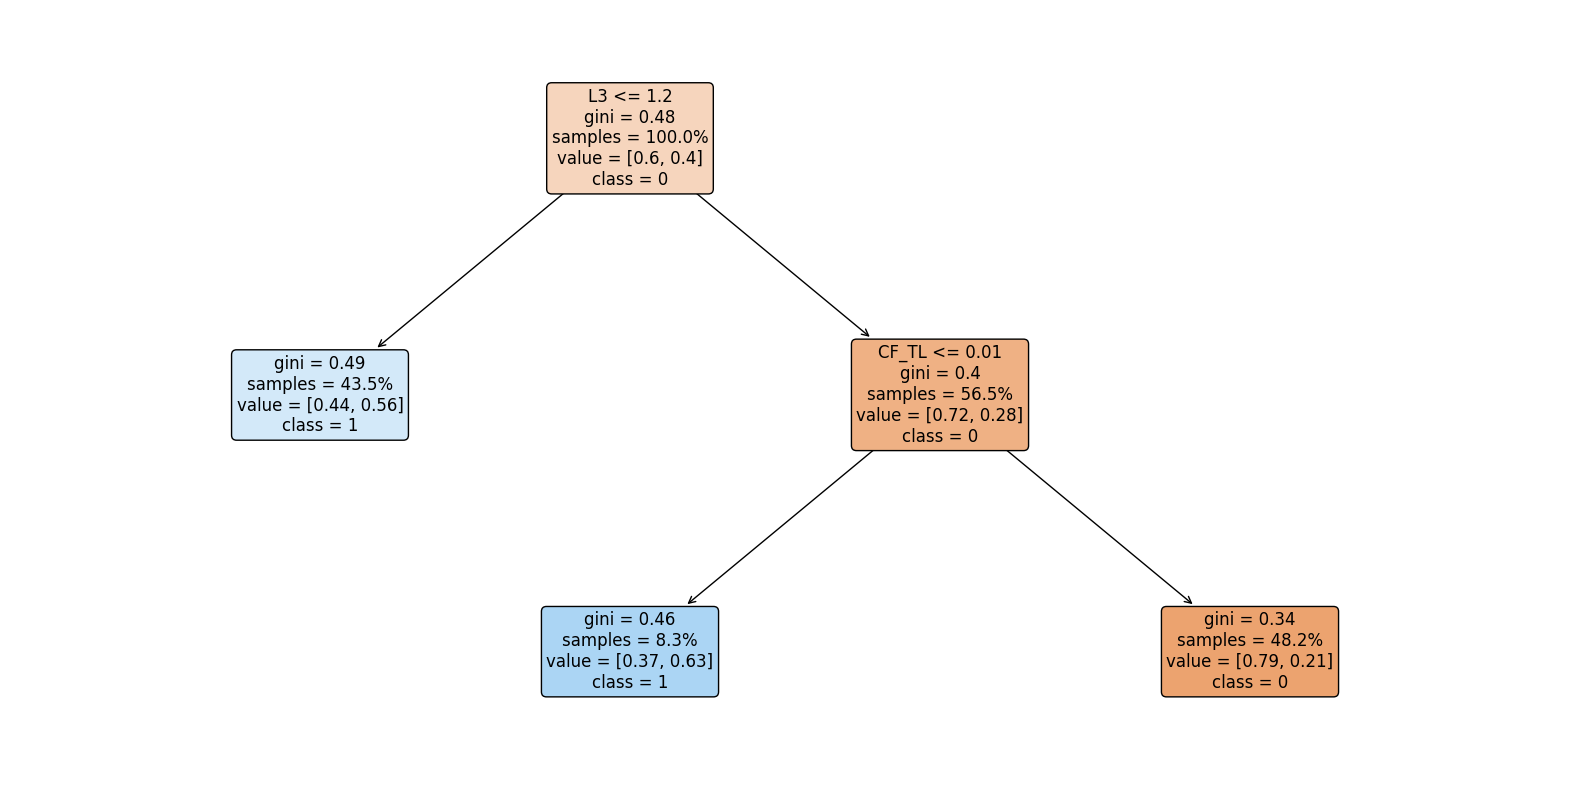

In [148]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree


plt.figure(figsize=(20,10))
plot_tree(rf_final, filled=True, feature_names=REDUCED_FEATURE_SET + SKNACE_ONE_HOT, class_names=['0', '1'], 
          rounded=True, proportion=True, precision=2, fontsize=12)
plt.show()
